#Background_Color(K-Means)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import os

#Plot Image

In [39]:
# Plot image
def plot_image(img):
  h, w, d = img.shape
  fig, ax = plt.subplots(figsize=(5,8))
  ax.axis('off')
  ax.imshow(img)

# Plot colors
def plot_colors(main_colors, to_int=False):
  if to_int:
    main_colors = np.array(main_colors)
    # 將array轉為整數
    main_colors = main_colors.astype('uint8')

  plt.figure(figsize=(12,12))
  plt.imshow([main_colors], aspect='auto')

  plt.axis('off')

  plt.show()

# Show main colors
def show_main_colors(main_colors, k, to_int=False):
  if to_int:
    main_colors = np.array(main_colors)
    # 將array轉換為整數
    main_colors = main_colors.astype('uint8')

  # 創建subplot，將三張圖片顯示在同一個視窗中
  fig, axs = plt.subplots(1, k)
  for i in range(k):
    axs[i].imshow([[main_colors[i]]])
    axs[i].set_title('Color {}'.format(i + 1))
    axs[i].axis('off')

  # 顯示圖表
  plt.show()

#K-Means Algorithm

##1.Sklearn的K-Means

In [40]:
# 1.Sklearn的K-Means
from sklearn.cluster import KMeans

def sk_kmeans(img, k):
  # 將圖片轉換為(height*width, dimension)的二維陣列
  h, w, d = img.shape
  img = img.reshape((h * w, d))

  kmeans = KMeans(n_clusters=k, random_state=0)
  kmeans.fit(img)

  main_colors = kmeans.cluster_centers_.astype(int)

  return main_colors

##2.Sample K-Means

In [41]:
# 2.Sample K-Means
def k_means(img, k, max_iterations=100):
  img = np.array(img)

  # 將圖片轉換為(height*width, dimension)的二維陣列
  h, w, d = img.shape
  img = img.reshape((h * w, d))

  # initialize centroids(k個中心點)
  centroids = img[np.random.choice(h*w, k, replace=False)]

  # 對每個pixel去找最近的中心點
  for i in range(max_iterations):
    # 距離 sum((x-c)^2)
    distance = np.sqrt( ((img - centroids[:, np.newaxis]) ** 2).sum(axis=2) ) # [:, np.newaxis]:會給列上增加維度
    # 取出最小距離的index
    cluster_labels = np.argmin(distance, axis=0)

    for j in range(k):
      if len(cluster_labels) != 0:
        # 更新群心
        centroids[j] = np.mean( img[cluster_labels == j], axis=0)

  main_colors = centroids.astype(int)

  return main_colors

##3.Mini Batch K_means

In [42]:
# 3.Mini Batch K_means
def mini_batch_k_means(img, k, batch_size, max_iterations=100):
  img = np.array(img)

  # 將圖片轉換為(height*width, dimension)的二維陣列
  h, w, d = img.shape
  img = img.reshape((h * w, d))

  # initialize centroids(k個中心點)
  centroids = img[np.random.choice(h*w, k, replace=False)]

  # 對每個pixel去找最近的中心點
  for i in range(max_iterations):
    # 用一個小的隨機子集（mini-batch)
    batch = img[np.random.choice(len(img), batch_size, replace=False)]
    
    # 距離 sum((x-c)^2)
    distance = np.sqrt( ((batch - centroids[:, np.newaxis]) ** 2).sum(axis=2) ) # [:, np.newaxis]:會給列上增加維度
    # 取出最小距離的index
    cluster_labels = np.argmin(distance, axis=0)

    for j in range(k):
      if len(cluster_labels) != 0:
        # 更新群心
        centroids[j] = np.mean( batch[cluster_labels == j], axis=0)

  main_colors = centroids.astype(int)

  return main_colors

##4.K-Means++

In [43]:
# 4.K-Means++
def kmeans_init(img, k):
  # 隨機選擇一個中心
  centroids = [img[np.random.randint(0, len(img))]]
  
  # 選擇k-1個聚類中心
  for i in range(1, k):
    # 計算每個樣本與目前已選擇聚類中心的距離
    dist = np.array([min([np.linalg.norm(x-c)**2 for c in centroids]) for x in img]) # np.linalg.norm計算兩個向量之間的歐幾里得距離
    
    # 計算每個樣本與已選擇聚類中心的最短距離
    probabilities = dist / dist.sum()
    # 按照概率選擇下一個聚類中心
    next_id = np.random.choice(len(img), p=probabilities)
    next_centroids = img[next_id]
    centroids.append(next_centroids)
      
  return np.array(centroids)

def k_means_plusplus(img, k, max_iterations=100):
  # 將圖片轉換為(height*width, dimension)的二維陣列
  h, w, d = img.shape
  img = img.reshape((h * w, d))

  # initialize centroids
  centroids = kmeans_init(img, k)

  # 對每個pixel去找最近的中心點
  for i in range(max_iterations):
    # 距離 sum((x-c)^2)
    distance = np.sqrt( ((img - centroids[:, np.newaxis]) ** 2).sum(axis=2) ) # [:, np.newaxis]:會給列上增加維度
    # 取出最小距離的index
    cluster_labels = np.argmin(distance, axis=0)

    for j in range(k):
      if len(cluster_labels) != 0:
        # 更新群心
        centroids[j] = np.mean( img[cluster_labels == j], axis=0)

  main_colors = centroids.astype(int)

  return main_colors

##5.K-Means (PCA-Part)

In [44]:
# 5.K-Means (PCA-Part)
def kmeans_PCA_Part(img, k):
  # 將圖片轉換為(height*width, dimension)的二維陣列
  h, w, d = img.shape
  img = img.reshape((h * w, d))


  # 初始化一個有所有點的單一群心
  centroids = [img]

  # repeat until K clusters are produced
  while len(centroids) < k:
    # 計算每個群集的內部SSE（Sum of Squared Errors）並返回最大值
    # 找到該集合中與平均向量距離最遠的向量
    selected_cluster = max(centroids, key=lambda c: np.sum((c - np.mean(c, axis=0))**2))
    

    # 選定群心的協方差矩陣
    covariance_matrix = np.cov(selected_cluster.T)
    # 計算協方差矩陣的1.特徵值和2.特徵向量
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    # 排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    # 找到第一主方向
    first_principal_direction = sorted_eigenvectors[:, 0]
    # 將每個資料點投影到第一主方向上
    projected_values = np.dot(selected_cluster - np.mean(selected_cluster, axis=0), first_principal_direction)
    

    # 中位數作為閾值
    threshold_value = np.median(projected_values)
    # 以閾值來切成兩個子群心
    sub_cluster_1 = selected_cluster[projected_values <= threshold_value]
    sub_cluster_2 = selected_cluster[projected_values > threshold_value]
    
    # 更新現有的群心
    centroids.remove(selected_cluster)
    centroids.append(sub_cluster_1)
    centroids.append(sub_cluster_2)

  main_colors = []
  for cluster in centroids:
    center = np.mean(cluster, axis=0)
    main_colors.append(center)
  return main_colors

#Main Function

In [45]:
# Main
def main(img, main_colors, k):
  while 1:
    final_img = []

    h, w, d = img.shape

    add_width = int(w / 4.5)
    add_height = int(h / 4.5)


    # 創建subplot，將三張圖片顯示在同一個視窗中
    fig, axs = plt.subplots(1, k, figsize=(15, 10))
    for i in range(k):
      # 背景顏色
      bg_color = main_colors[i]

      # 新建一個比圖片大的畫布
      new_image = np.ones((h+add_height, w+add_width, 3), dtype=np.uint8) * bg_color

      # 繪製圖片
      new_image[int(add_height/2):h+int(add_height/2), int(add_width/2):w+int(add_width/2), :] = img
      final_img.append(new_image.astype("uint8"))
      axs[i].imshow(new_image.astype("uint8"))
      axs[i].set_title('Color {}'.format(i + 1))
      axs[i].axis('off')

    # 顯示圖表
    plt.show()

    flag = input("[1]: Choose this [2]: Give up choice :")
    if flag == '1':
      num = int(input("Choose number you want: "))
      file_name = input("Input your file name: ")
      if not os.path.isdir('./output_images'):
          os.mkdir('./output_images')
      plt.imsave('./output_images/' + file_name + '.jpg', final_img[num-1])
      break
    elif flag == '2':
      break

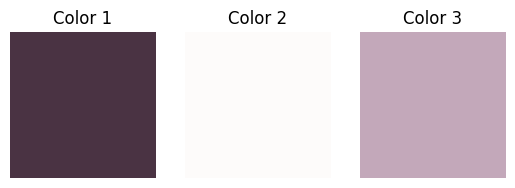

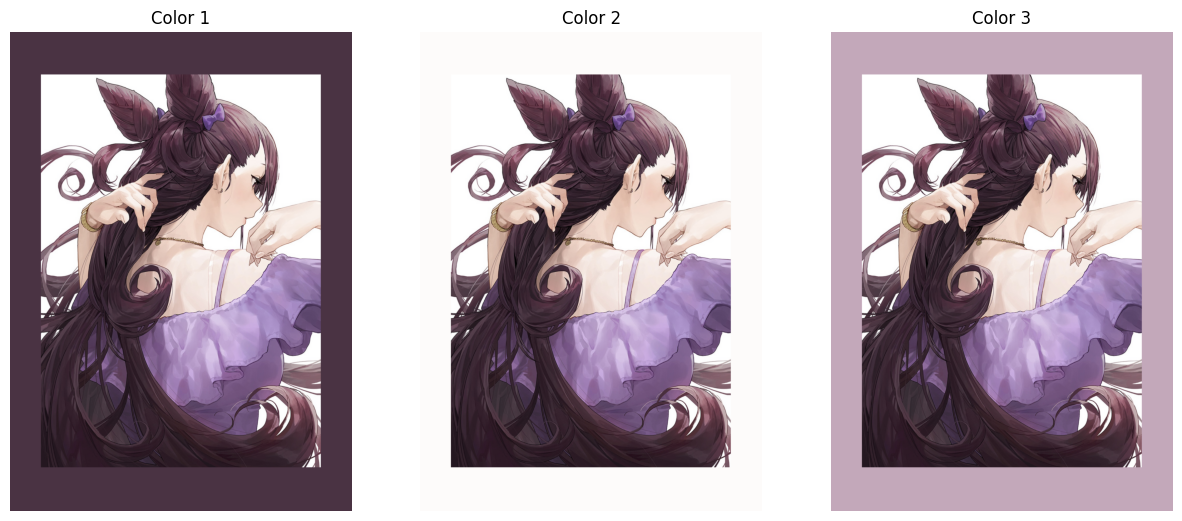

[1]: Choose this [2]: Give up choice :1
Choose number you want: 1
Input your file name: p1


In [46]:
img = plt.imread('input_images/p1.jpg')
k = 3
max_iterations = 150
batch_size = 128

# # 1.Sklearn的K-Means
# main_colors = sk_kmeans(img, k)

# # 2.Sample K-Means
# main_colors = k_means(img, k, max_iterations)

# # 3.Mini Batch K_means
# main_colors = k_means(img, k, batch_size, max_iterations)

# 4.K-Means++
# main_colors = k_means_plusplus(img, k, max_iterations)

# # 5.K-Means (PCA-Part)
main_colors = kmeans_PCA_Part(img, k)

show_main_colors(main_colors, k, to_int=True)

main(img, main_colors, k)